<img src="images/arm_logo.png" width=500 alt="ARM Logo"></img>

# Bankhead National Forest - RadCLss Timeseries

## Overview

The Extracted Radar Columns and In-Situ Sensors (RadClss) Value-Added Product (VAP) is
a dataset containing in-situ ground observations matched to CSAPR-2 radar columns above ARM Mobile Facility (AMF-3) supplemental sites of interest. 

RadCLss is intended to provide a dataset for algorthim development and validation of precipitation retrievals.

## Prerequisites

| Concepts | Importance | Notes |
| --- | --- | --- |
| [Intro to Cartopy](https://foundations.projectpythia.org/core/cartopy/cartopy.html) | Necessary | |
| [Understanding of NetCDF](https://foundations.projectpythia.org/core/data-formats/netcdf-cf.html) | Helpful | Familiarity with metadata structure |
| [GeoPandas](https://geopandas.org/en/stable/docs.html) | Necessary | Familiarity with Geospatial Plotting|
| [Py-ART / Radar Foundations](https://projectpythia.org/radar-cookbook/README.html) | Necessary | Basics of Weather Radar | 

- **Time to learn**: 30 minutes

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import os
import glob
import datetime

import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import dask
import cartopy.crs as ccrs

from math import atan2 as atan2
from datetime import timedelta
from cartopy import crs as ccrs, feature as cfeature
from cartopy.io.img_tiles import OSM
from matplotlib.transforms import offset_copy
from dask.distributed import Client, LocalCluster
from metpy.plots import USCOUNTIES
from mpl_toolkits.axes_grid1 import make_axes_locatable

import act
import pyart

dask.config.set({'logging.distributed': 'error'})


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



## Define the Input File and Open

In [ ]:
# Define the desired processing date for the BNF CSAPR-2 in YYYY-MM-DD format.
DATE = "2025-04-06"
# Define the directory where the BNF CSAPR-2 RadCLss files are located.
RADCLSS_DIR = os.getenv("BNF_RADCLSS_DIR")

In [35]:
# Define a site of interest
dis_site = "M1"
# Define the field of interest
field = "corrected_reflectivity"
# Define the min/max
vmin = -10
vmax = 65
rheight = 1200

In [32]:
# With the user defined RADAR_DIR, grab all the XPRECIPRADAR CMAC files for the defined DATE
file_list = sorted(glob.glob(RADCLSS_DIR + 'bnfcsapr2radclssS3.c2.' + DATE.replace('-', '') + '*.nc'))
file_list

['/nfs/gce/globalscratch/obrienj/bnf-radclss-v5/bnfcsapr2radclssS3.c2.20250406.000000.nc']

In [33]:
ds = xr.open_dataset(file_list[0])

## Display Figure

In [40]:
ds = ds.sel(time=slice("2025-04-06T05:00:00", "2025-04-06T15:00:00"))

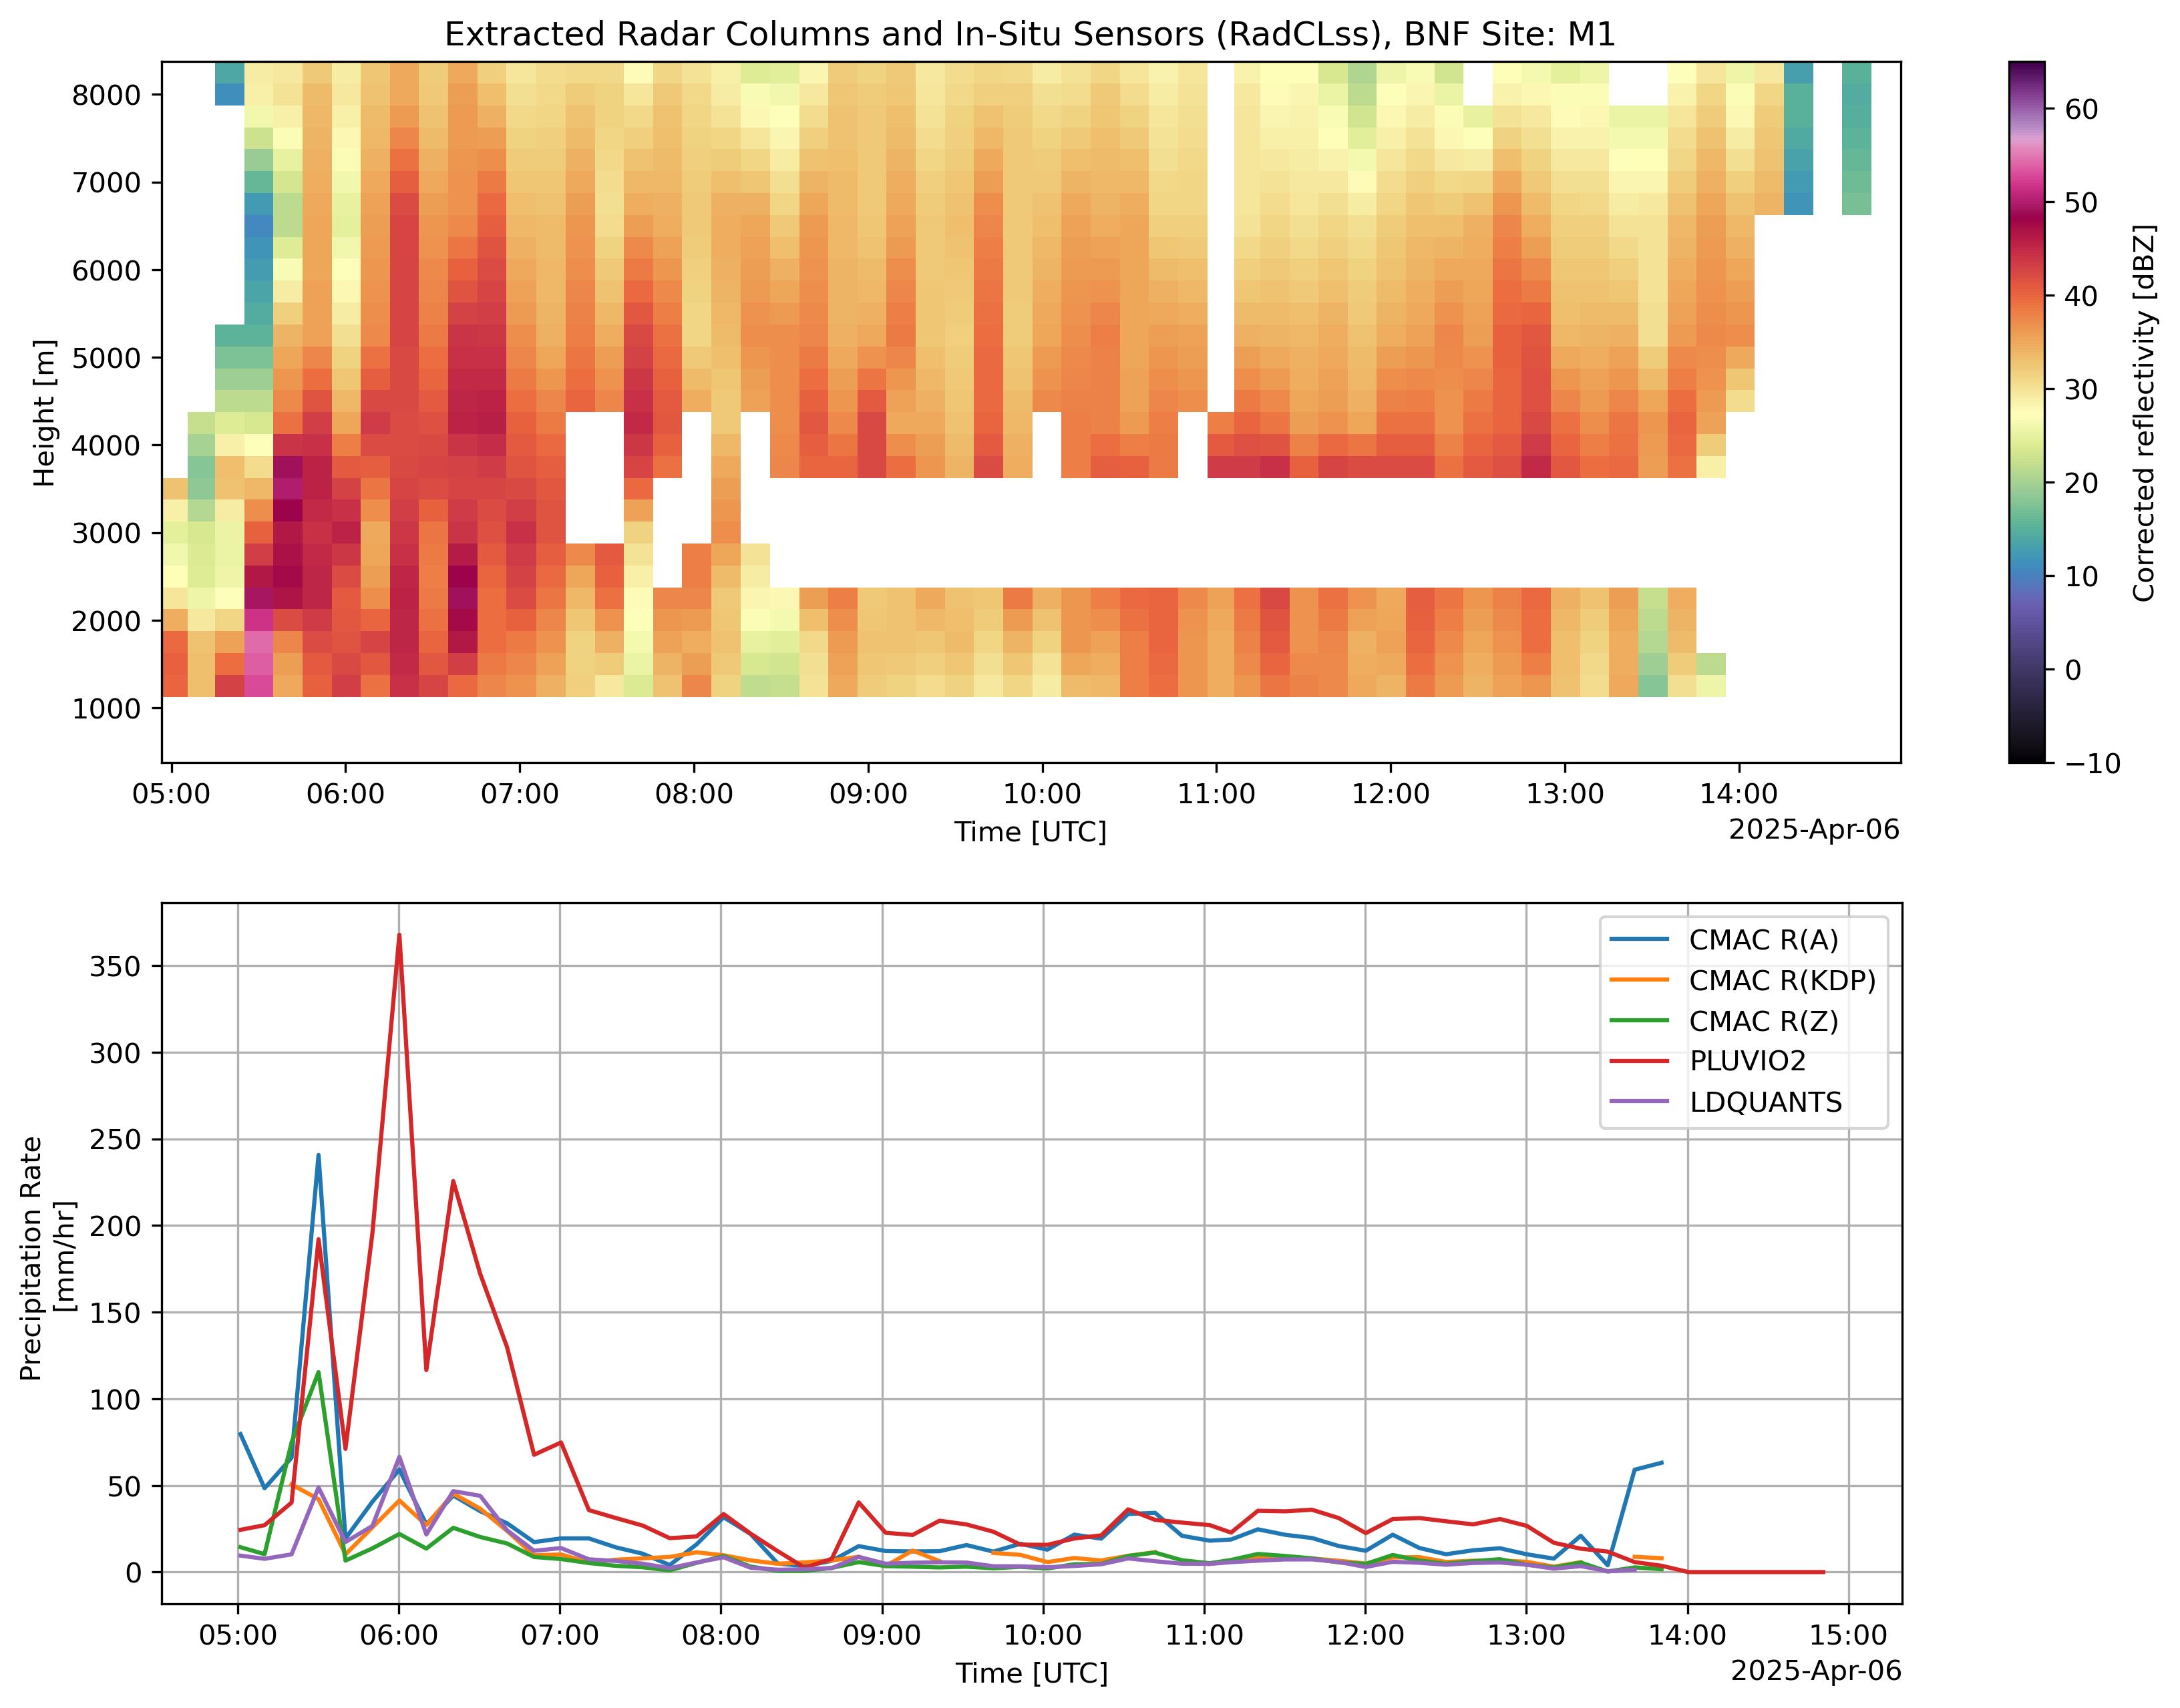

In [44]:
# Create the figure
fig = plt.figure(figsize=(14, 10))
plt.subplots_adjust(wspace=0.0)

# Define the time of the radar file we are plotting against
radar_time = datetime.datetime.strptime(np.datetime_as_string(ds['time'].data[0], unit="s"), 
                                        "%Y-%m-%dT%H:%M:%S")
final_time = radar_time + timedelta(days=1)

#-----------------------------------------------
# Side Plot A - Display the RadClss Radar Field
#-----------------------------------------------
# Top right hand subplot - Radar TimeSeries
ax2 = fig.add_subplot(211)

ds[field].sel(station=dis_site).plot(x="time", 
                                     ax=ax2, 
                                     cmap="ChaseSpectral",
                                     vmin=vmin,
                                     vmax=vmax
)
    
ax2.set_title("Extracted Radar Columns and In-Situ Sensors (RadCLss), BNF Site: " + 
              dis_site)
ax2.set_ylabel("Height [m]")
ax2.set_xlabel("Time [UTC]")

#--------------------------------------
# Side Plot B - Display the Rain Rates
#--------------------------------------
# Top right hand subplot - Radar TimeSeries
ax3 = fig.add_subplot(212)

# CMAC derived rain rate
ds["rain_rate_A"].sel(station=dis_site).sel(
    height=rheight, method="nearest").plot(x="time", 
                                           ax=ax3,
                                           label="CMAC R(A)"
)

# CMAC derived rain rate
ds["rain_rate_Kdp"].sel(station=dis_site).sel(
    height=rheight, method="nearest").plot(x="time", 
                                           ax=ax3,
                                           label="CMAC R(KDP)"
)

# CMAC derived rain rate
ds["rain_rate_Z"].sel(station=dis_site).sel(
    height=rheight, method="nearest").plot(x="time", 
                                           ax=ax3,
                                           label="CMAC R(Z)"
)

# Pluvio2 Weighing Bucket Rain Gauge
if dis_site == "M1":
    ds["intensity_rtnrt"].sel(station=dis_site).plot(x="time",
                                                     ax=ax3,
                                                     label="PLUVIO2"
    )

# LDQUANTS derived rain rate
if dis_site == "M1" or dis_site == "S30":
    ds["ldquants_rain_rate"].sel(station=dis_site).plot(x="time",
                                                   ax=ax3,
                                                   label="LDQUANTS"
    )
            
ax3.set_title(" ")
ax3.set_ylabel("Precipitation Rate \n[mm/hr]")
ax3.set_xlabel("Time [UTC]")
##ax3.set_xlim([radar_time.strftime("%Y-%m-%dT00:00:00"), 
##              final_time.strftime("%Y-%m-%dT00:00:00")])
ax3.legend(loc="upper right")
ax3.grid(True)
# Add a blank space next to the subplot to shape it as the above plot
divider = make_axes_locatable(ax3)
cax = divider.append_axes("right", size="3%", pad=1.9)
cax.set_visible(False)

# Set the DPI to a higher value (e.g., 300)
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300